In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture

19.05.2022 11:43:15 Creating Training Directory at 2022-05-19_11-43_Diff_CG_Classifier/
19.05.2022 11:43:15 Loading Datasets
19.05.2022 11:43:15 Start Training


Epoch 0: Training loss 14.9448; Validation loss 15.2123, MAE: 13.9378; lr: 0.01000
	Add. Loss: Training 1.7512, Validation 2.0918
Epoch 5: Training loss 7.7361; Validation loss 16.4574, MAE: 15.3030; lr: 0.01000
	Add. Loss: Training 1.6121, Validation 2.0155
Epoch 10: Training loss 7.0600; Validation loss 16.8950, MAE: 15.8539; lr: 0.01000
	Add. Loss: Training 1.5053, Validation 1.8891
Epoch 15: Training loss 6.4438; Validation loss 16.1766, MAE: 15.4420; lr: 0.01000
	Add. Loss: Training 1.2383, Validation 1.5667
Epoch 20: Training loss 11.6442; Validation loss 15.5290, MAE: 15.0513; lr: 0.01000
	Add. Loss: Training 0.9275, Validation 1.3973
Epoch 25: Training loss 6.5948; Validation loss 16.2206, MAE: 16.1648; lr: 0.01000
	Add. Loss: Training 0.6929, Validation 1.0120
Epoch 30: Training loss 6.1578; Validation loss 14.5748, MAE: 14.3299; lr: 0.01000
	Add. Loss: Training 0.7150, Validation 1.1638
Epoch 35: Training loss 5.8852; Validation loss 15.0254, MAE: 15.0693; lr: 0.01000
	Add. L

19.05.2022 12:28:24 Training took 0.75 hours
19.05.2022 12:28:24 Minimum Training Loss 0.1931 in epoch 4896
19.05.2022 12:28:24 Minimum Validation Loss (after 50 epochs) 12.9850 in epoch 251
19.05.2022 12:28:24 Minimum MAE (after 50 epochs) 13.2990 in epoch 251
19.05.2022 12:28:24 Seed used for training was: 15643491548014798865


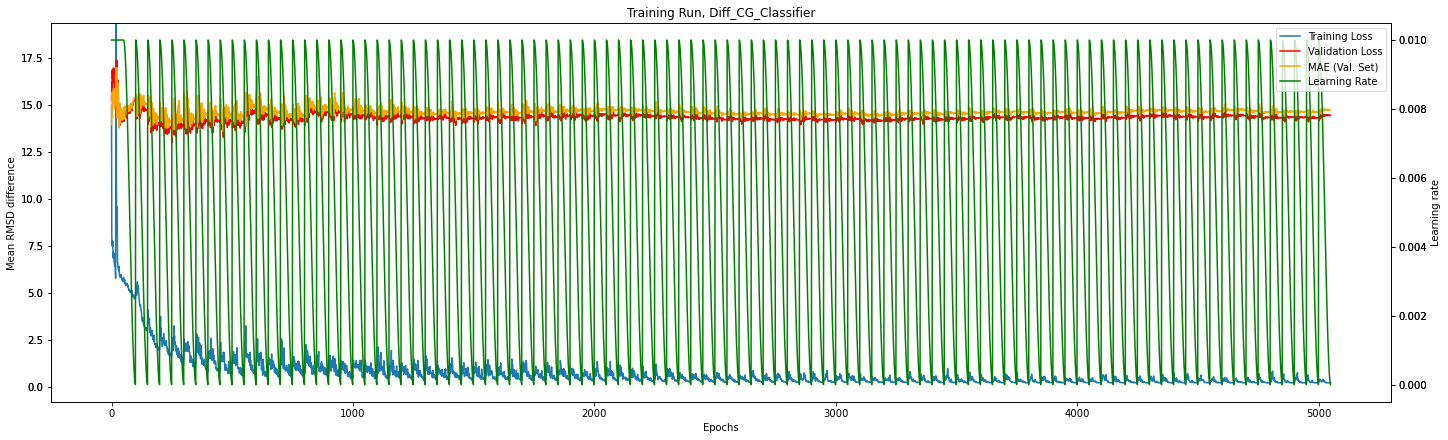

In [7]:
#Training
model = Diff_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-2,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=50)

In [8]:
#get training run data

run_dir = "run_data/2022-05-19_11-43_Diff_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.1931 in epoch 4896
Minimum Validation Loss (after 50 epochs) 12.9850 in epoch 251
Minimum MAE (after 50 epochs) 13.2990 in epoch 251


In [22]:
print(len(epoch_losses))

5050


Validation Loss at 251 is 12.9850
5 before select
13.8235, 13.8307, 13.8456, 13.8480, 13.4618
5 after select
13.7956, 13.9046, 13.9195, 13.6820, 13.7420
MAE at 251 is 13.2990


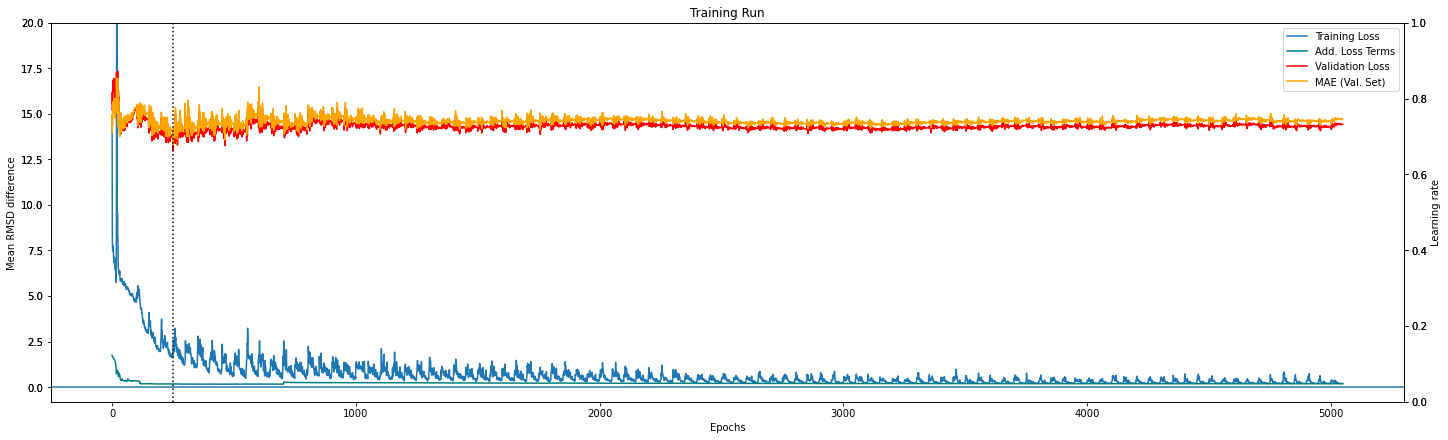

In [9]:
#plot the training run
select = 251

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 251
Test Set
Minimum Loss: Label = 23.4710, Prediction = 23.4973, Loss = 0.0003
Maximum Loss: Label = 0.0000, Prediction = 23.5113, Loss = 23.0113
Mean Test loss: 	 11.0838
Std. Dev. of Test loss:  8.3332
Min loss: 		 0.0003
First Quantile: 	 3.3407
Median: 		 10.3453
Third Quantile: 	 21.2459
Max Loss: 		 23.0113
LinregressResult(slope=-517.5363696879225, intercept=12180.370397275528, rvalue=-0.20719975342434688, pvalue=0.0005192273636856823, stderr=147.3522430542883, intercept_stderr=3463.190999060433)


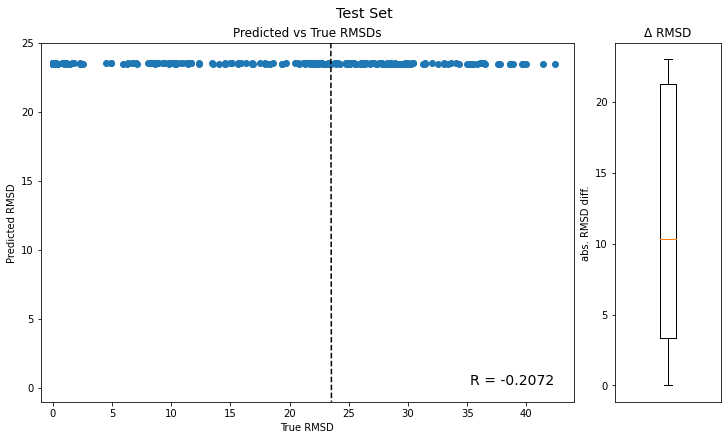

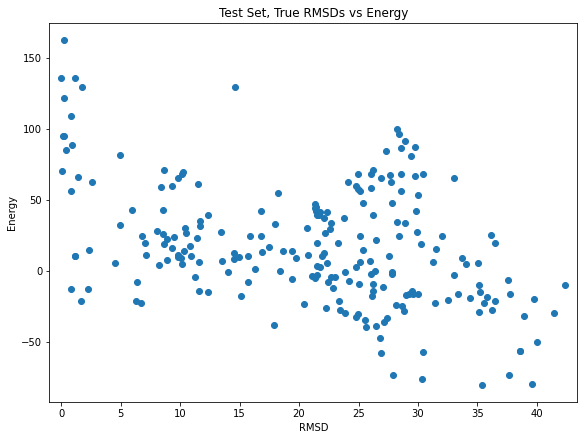

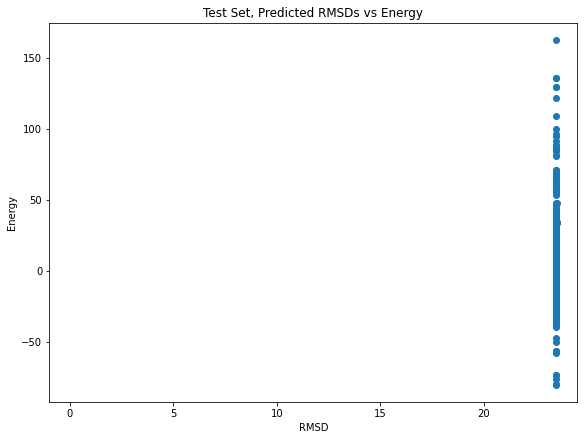

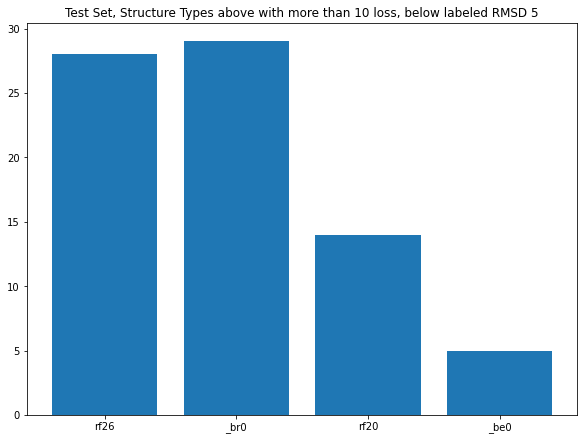

5S and tRNA Test Set
Minimum Loss: Label = 23.5110, Prediction = 23.4961, Loss = 0.0001
Maximum Loss: Label = 0.0000, Prediction = 23.5176, Loss = 23.0176
Mean Test loss: 	 8.3440
Std. Dev. of Test loss:  7.6949
Min loss: 		 0.0001
First Quantile: 	 2.6219
Median: 		 5.5260
Third Quantile: 	 10.7686
Max Loss: 		 23.0176
LinregressResult(slope=-37.840360269658404, intercept=905.0140183227315, rvalue=-0.0181795116519156, pvalue=0.550088566786304, stderr=63.297772184737, intercept_stderr=1487.282385458154)


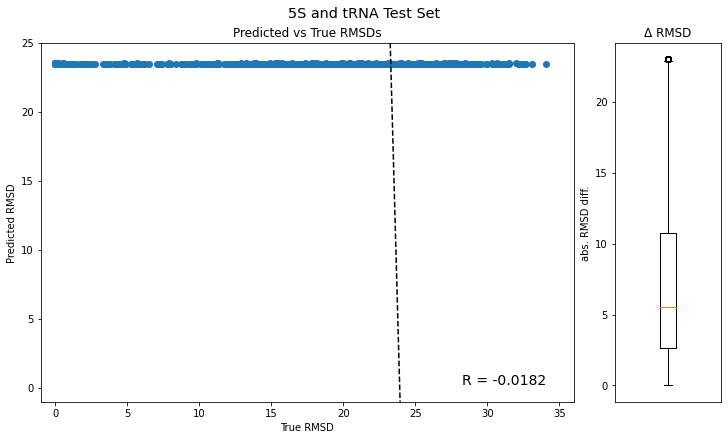

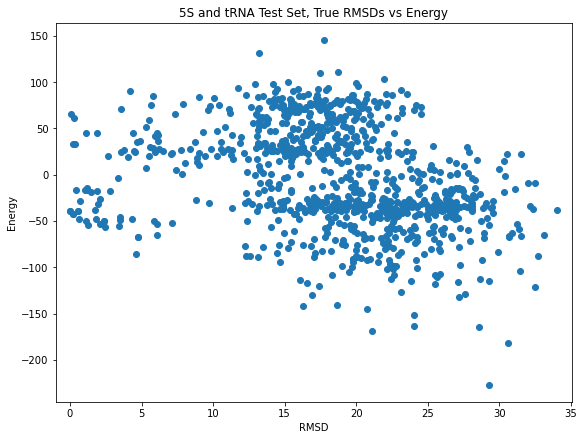

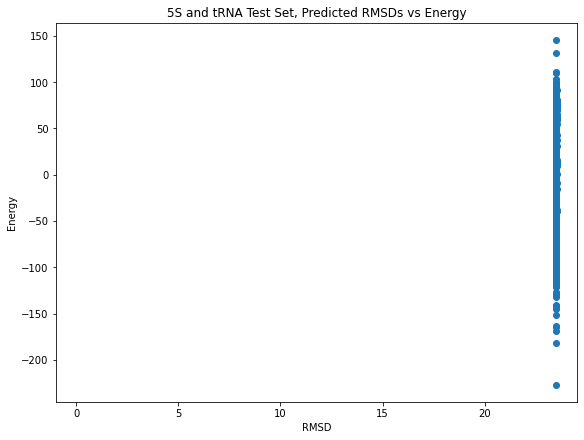

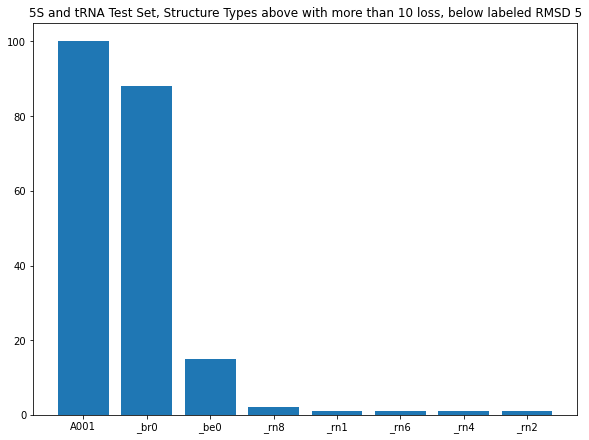

Training Set
Minimum Loss: Label = 23.5100, Prediction = 23.4939, Loss = 0.0001
Maximum Loss: Label = 0.0000, Prediction = 23.4996, Loss = 22.9996
Mean Test loss: 	 8.1493
Std. Dev. of Test loss:  6.3907
Min loss: 		 0.0001
First Quantile: 	 3.0479
Median: 		 6.6778
Third Quantile: 	 11.8781
Max Loss: 		 22.9996
LinregressResult(slope=-960.8651581994994, intercept=22593.80821943712, rvalue=-0.15612854639027796, pvalue=1.5348719986219423e-05, stderr=220.79373029491583, intercept_stderr=5187.63685158477)


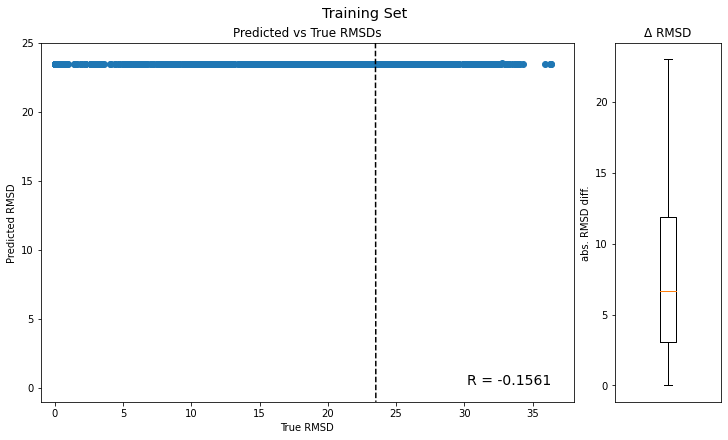

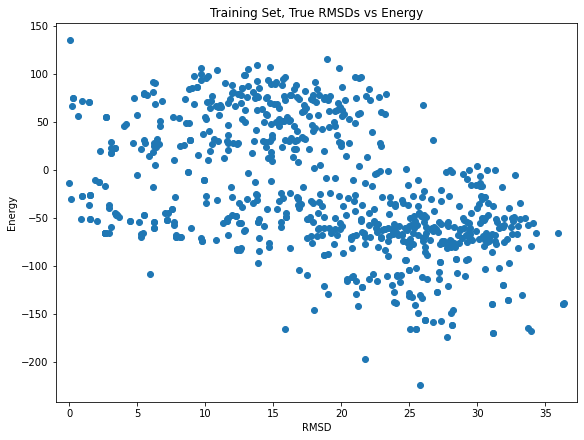

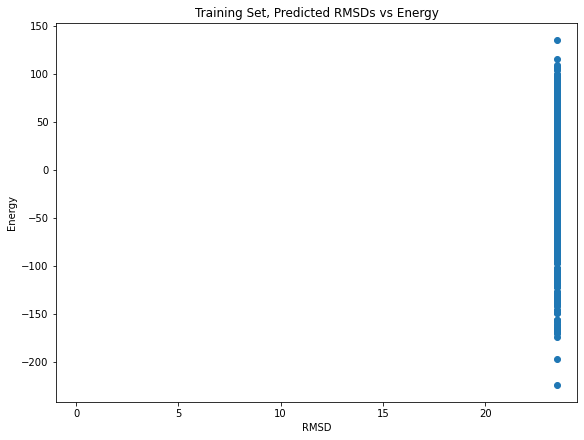

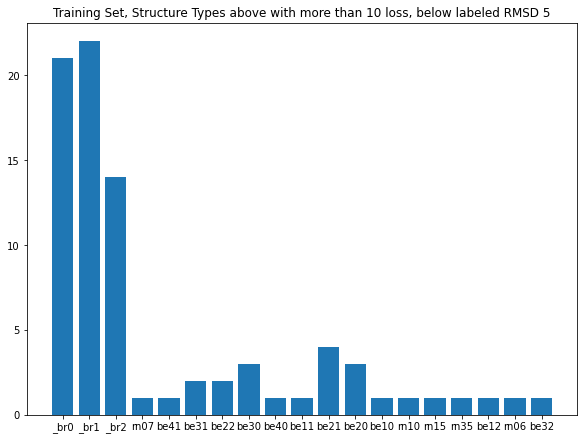

KeyboardInterrupt: 

In [10]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9904729941123832, intercept=0.23782421087207695, rvalue=0.9864665124143727, pvalue=5.530477112058963e-218, stderr=0.009927489433706188, intercept_stderr=0.21827524890281924)


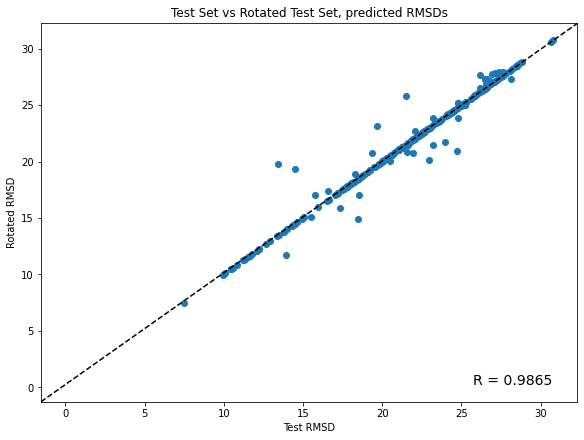

LinregressResult(slope=1.0016714732799976, intercept=0.014074999694654977, rvalue=0.9957366070808834, pvalue=1.0946521807944944e-286, stderr=0.005595562828750237, intercept_stderr=0.07854116481145301)


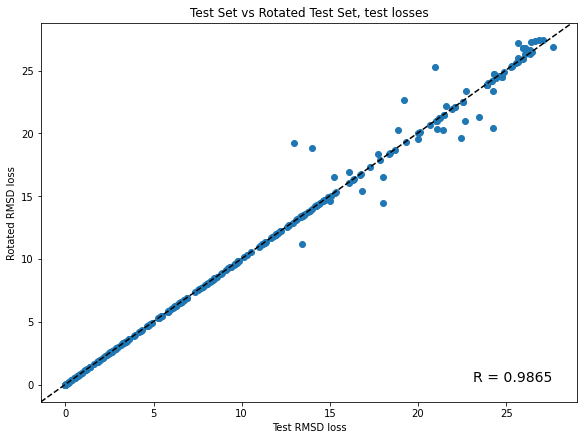

LinregressResult(slope=0.9529774740679942, intercept=0.9527961526930859, rvalue=0.9597189776493851, pvalue=0.0, stderr=0.008485410301435334, intercept_stderr=0.16048421285455455)


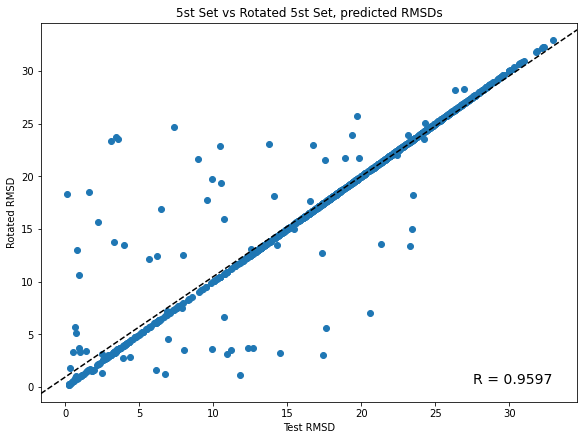

LinregressResult(slope=0.9478541115220577, intercept=0.33573970127671693, rvalue=0.8844301989571179, pvalue=0.0, stderr=0.015211684126447305, intercept_stderr=0.08751254584111483)


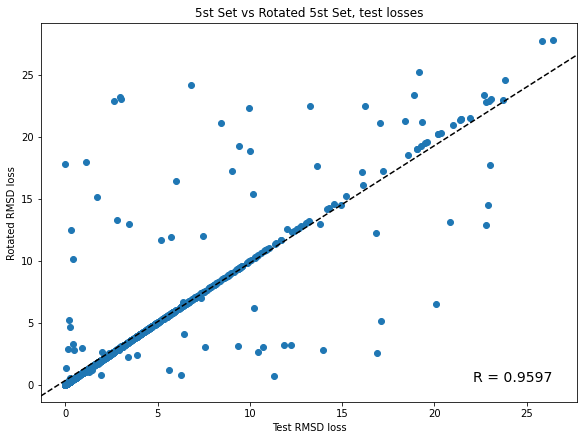

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")